# Social Dynamics Model
 Isaac Schaal - CS 166
 
 ## Overview of the Model
 
 The model being analyzed in this paper is a social dynamic network model. In the model, nodes represent indiviudals, and they each have an "opinion" between 0 and 1. This can be thought of as a controversial topic which people have varying opinions about, like polotics or religion. A value of 0 or 1 is an extreme belief on either side, with .5 being a moderate opinion. The edges in the model represent friendships between two nodes, with a higher weight meaning a stronger relationship. An edge can have a maximum weight of 1, and edges with weights less than 0.05 are deleted, signifying an end to a relationship. 
 
The model is initialized with random opinion values for all nodes and random connections between nodes, all with weight 0.5. Then, an update step is run. The update step signifies a conversation between two nodes. The two nodes are having a conversation about the subject they each have opinions about. Each time they have a conversation, the opinion values for both nodes and the weight of the edge between the nodes are changed. In the real world, this represents a conversation in which both people become closer to each others opinions by hearing and talking about the subject with the other person. When a conversation happens between node $i$ and $j$, the change in the opinion of node $i$ is determined by the following equation.
 
 $$ \Delta o_i  = \alpha w_{ij} (o_j - o_i)$$
 
In this equation, $\alpha$ with ($\alpha \in (0,0.5] $) represents the rate at which nodes adjust their opinions. With a higher $\alpha$ nodes change their opinions faster, and vice versa. It is also important to note that both the weight of the relationship $w_{ij}$ and the difference between the opinions of the nodes $(o_j - o_i)$ both change the rate of opinion change. A stronger relationship and a larger differnce in opinion both lead to a larger change in opinion. Finally, it is important to note that the change in opinion is equal for both node $i$ and node $j$, just in the opposite directions (towards the middle).

During the same interaction, the edge weight is changed. If people are similar in opinion to each other, the edge weight will increase, but if they disagree their edge weight will decrease. In the real world, people will strengthen relationships with people who have they have positive conversations with (they agree) and weaken their relationships with people they disagree with. This interaction is modeled by the following equation.

$$\Delta w_{ij} = \beta w_{ij} (1 - w_{ij})(1 - \gamma |o_i - o_j |)  $$

In this equation $ \beta \in (0,1) $ and $\gamma >0 $ are parameters. Note that $\beta $ is the rate at which edge weights change in response to conversations and $\gamma$ is the pickiness of nodes, or the difference needed in opinions for nodes to either increase or decrease the edge weight. If $\gamma ≤1 $, all weights will converge, but if $ \gamma > 1$, the weight between nodes will decrease if the difference in opinions satisfy $ |o_i - o_j| > \gamma ^{-1} $. If an edge weight falls below 0.05, it is deleted.

Finally, with probability 0.01, a new social connections is added to the graph instead of an update converstaion between two nodes. This connection is made between two nodes who are not already connected and starts with a weight of 0.5. This models real life interactions in which people meet each other by chance and become friends. 

The implementation of this model is seen below.

In [609]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
%matplotlib inline

In [516]:
#Basic Implementation

class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
    
    #this method was added for better visualization
    def update_layout(self):
        '''
        Update the layout of the network without drawing it.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

## Initial Analysis

When analyzing this model, the main outcome we are looking for is if the network converges or diverges. A convergent network is one where all or most nodes form one large interconnected group with similar opinions, while a divergent network is one where nodes form two or more groups that are interconnected and not very connected to other groups and opinions are similar in their own group but different than other groups. Whether a network converges or diverges depends on the initial parameters. For our analysis, we will see if a network converges or diverges after 20,000 updates of the model.

An example of a convergent network can be seen below

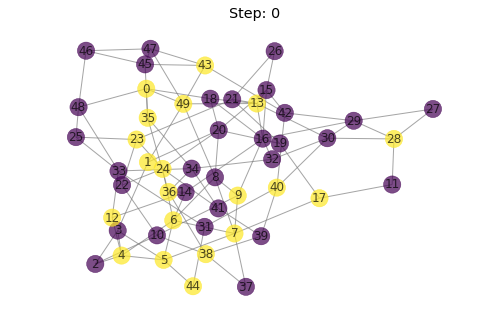

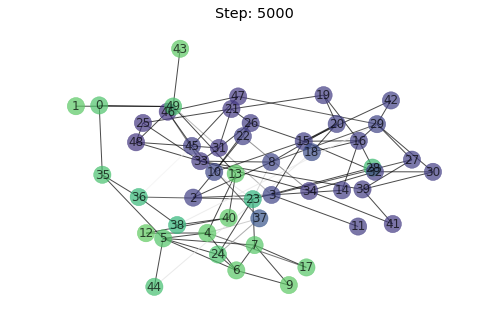

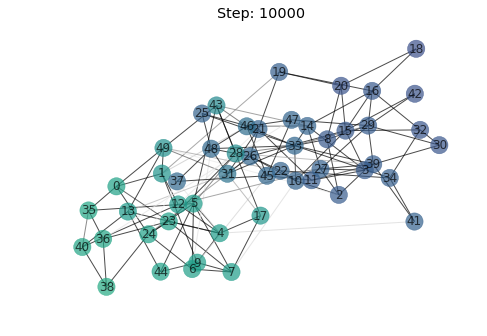

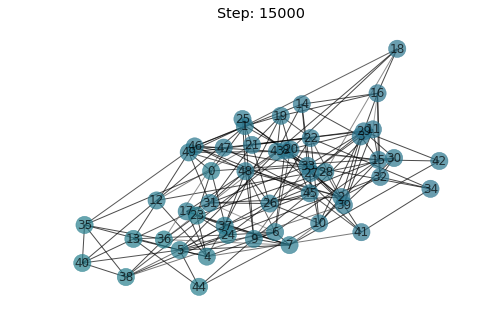

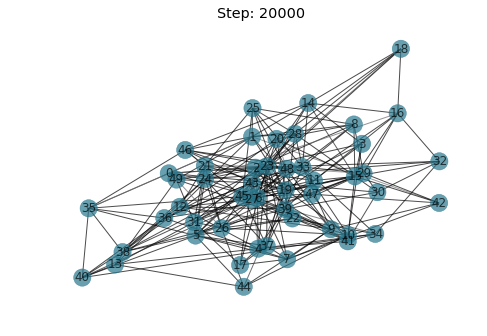

In [518]:
sim_converge = SocialDynamicsSimulation(alpha = 0.06, beta = 0.2, gamma = 4)
sim_converge.initialize()
sim_converge.observe()
for i in range(4):
    for i in range(5000):
        sim_converge.update()
    plt.figure()
    sim_converge.observe()

And an example of a divergent network is shown below. 

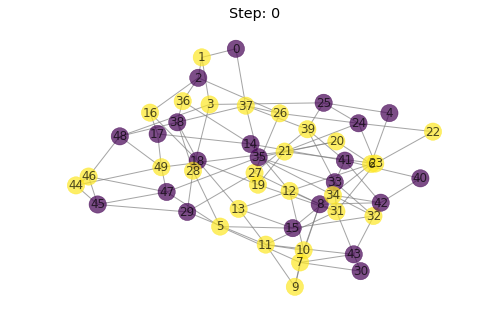

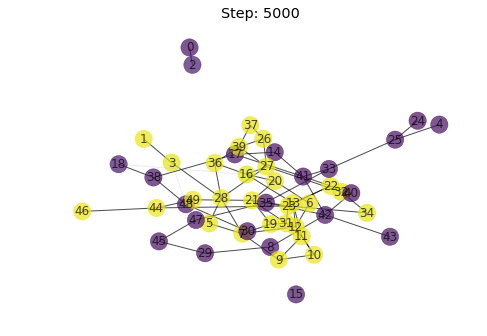

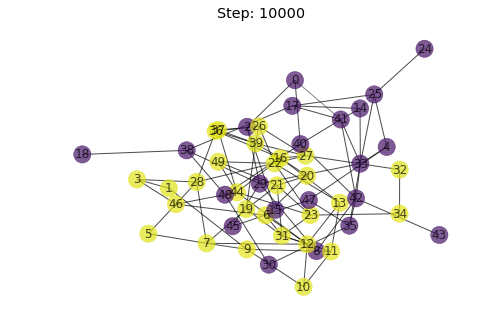

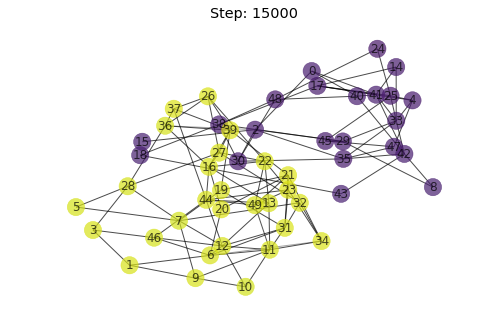

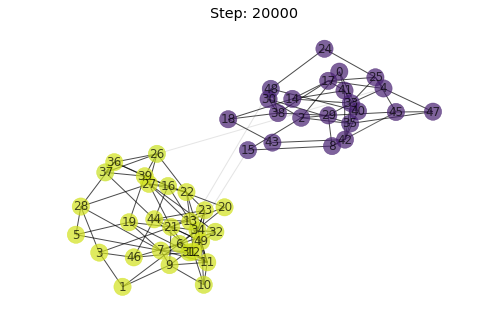

In [520]:
sim_diverge = SocialDynamicsSimulation(alpha = 0.02, beta = 0.6, gamma = 4)
sim_diverge.initialize()
sim_diverge.observe()
for i in range(4):
    for i in range(5000):
        sim_diverge.update()
    plt.figure()
    sim_diverge.observe()

From observing the previous two models, it is easy to see their respective convergence and divergence. However, what we would like to do is define some sort of objective metric that can determine if a network converges or diverges. Many aspects of the graphs are similar. However, if we look at a scatter plot of the opinions and the associated standard deviation, we can see clear differences.

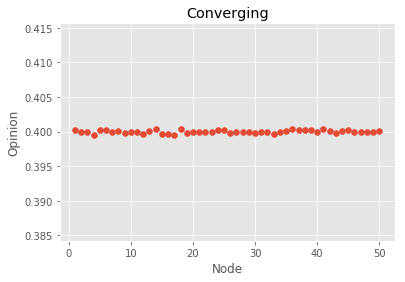

Converging Standard Deviation is : 0.000209134922918


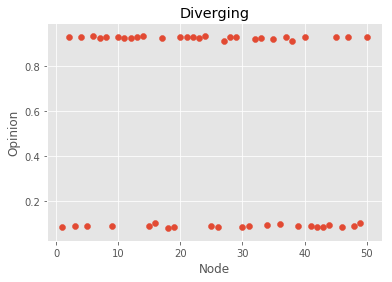

Diverging Standard Deviation is : 0.415629326044


In [525]:
def scatter_and_std(sim, title):
    lis = []
    for i in list(sim.graph.nodes()):
        lis.append(sim.graph.nodes[i]['opinion'])
    plt.title(title)
    plt.scatter([x for x in range(1,51)],lis)
    plt.xlabel("Node")
    plt.ylabel("Opinion")
    plt.show()
    print (title, "Standard Deviation is :",np.std(lis))

scatter_and_std(sim_converge, "Converging")
scatter_and_std(sim_diverge, "Diverging")



Now, we know that the standard deviation can serve as a metric for determining convergence. We now need to find a cuttoff point.

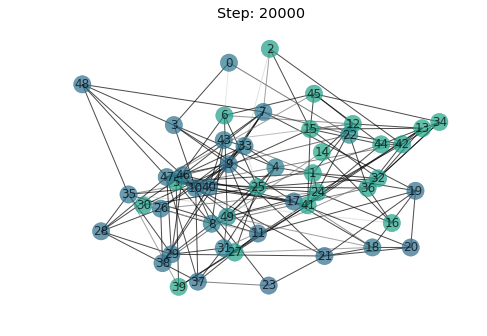

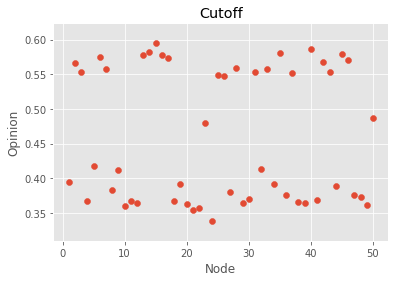

Cutoff Standard Deviation is : 0.0950387407011


In [569]:
sim_cutoff = SocialDynamicsSimulation(alpha = 0.07, beta = 0.4, gamma = 4)
sim_cutoff.initialize()
for i in range(4):
    for i in range(5000):
        sim_cutoff.update()
plt.figure()
sim_cutoff.observe()

plt.figure()
scatter_and_std(sim_cutoff, "Cutoff")



This graph shows that with a standard deviation of 0.095, the graph still clearly has two distinct groups, thus we will need a lower cutoff for our std.

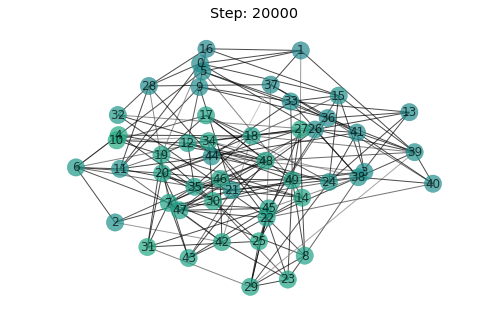

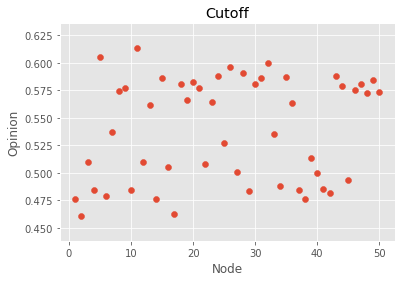

Cutoff Standard Deviation is : 0.0469694859883


In [571]:
sim_cutoff = SocialDynamicsSimulation(alpha = 0.075, beta = 0.4, gamma = 4)
sim_cutoff.initialize()
for i in range(4):
    for i in range(5000):
        sim_cutoff.update()
plt.figure()
sim_cutoff.observe()

plt.figure()
scatter_and_std(sim_cutoff, "Cutoff")

This graph shows the nodes much less as two distinct groups but instead a looselt cohesive group. It is not the extremely low standard deviation we saw on the very converged group, but in general it would be consdired a convergent group, due to the close opinion (maximum differnce quite close) and interconnectivity of the nodes. From this, I chose a standard deviation of 0.05 as a cutoff for being divergent. If a graph has a standard deviation of less than 0.05, it is a convergent graph. 

With this metric determined, it is possible to do some analysis as to how changing the parameters changes if a model will converge or diverge. With large amounts of computational power, a full parameter sweep could have been conducted. However, there are 3 variables (alpha, beta, and gamma) that contribute to the set up of the model. Each run of the simulation takes approximately 1 second. If we were to vary all 3 covariates (say with 20 different levels) we would have a 20 x 20 x 20 = 8,000 simulations, and if we were to repeat each simulation a few times to ensure accuracy, we would have 8,000 x 5 = 40,000 simulations, and 40,000 / 60 / 60 = 10 hours of simulation time. This is an unreasonably large amount of computational time (though could be run with modern cloud computing technology). 

However, we can still do meaningful analysis. What we can see if how an increase or decrease in the three parameters affects the result of the simulation. We can first do this with varying alpha and beta and holding gamma constant. Alpha and beta are the rates of change of opinions and relationship strengths, and thus are the natural pair to test together. A paramter sweep along these two values is conducted below. Each simulation is repeated 6 times, and if 3 or more are convergent, that paramter set is convergent (and divergent if not).

In [606]:
alpha_list = np.linspace(0.01,.1, 10)
beta_list = np.linspace(0.05, 0.95, 10)
gamma = 4
repeats = 6

def converge_test(alpha, beta, gamma, repeats):
    avg_list = []
    for _ in range(repeats):
        sim = SocialDynamicsSimulation(alpha = alpha, beta = beta, gamma = gamma)
        sim.initialize()
        for i in range(20000):
            sim.update()
        lis = []
        for i in list(sim.graph.nodes()):
            lis.append(sim.graph.nodes[i]['opinion'])
        std = (np.std(lis))
        if std >= 0.05:
            avg_list.append(0)
        else:
            avg_list.append(1)
    if sum(avg_list) >= np.floor(repeats/2.0):
        return (1)
    else:
        return (0)

results = []
for alpha in alpha_list:
    for beta in beta_list:
        results.append(converge_test(alpha, beta, gamma, repeats))
    print (alpha, "complete")

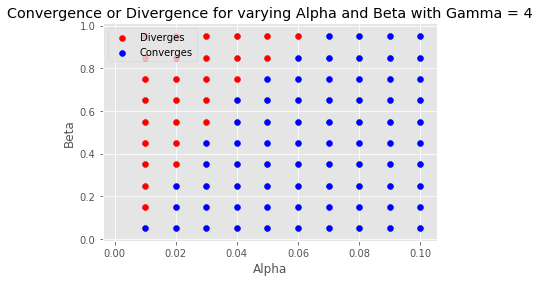

In [497]:
np_alpha = np.array(alpha_list )
np_beta = np.array (beta_list )


mat = np.meshgrid(np_alpha, np_beta)
mat_conv = [[],[]]
mat_div = [[],[]]

for i in range(10):
    for j in range(10):
        if results[10*i + j] == 1:
            mat_conv[0].append(mat[0][i][j])
            mat_conv[1].append(mat[1][i][j])
        else:
            mat_div[0].append(mat[0][i][j])
            mat_div[1].append(mat[1][i][j])
      
    

#Show the plot   
plt.style.use('ggplot')
plt.title("Convergence or Divergence for varying Alpha and Beta with Gamma = 4")
plt.scatter(mat_conv[0], mat_conv[1], c = 'r', label = "Diverges")
plt.scatter(mat_div[0], mat_div[1], c = 'b', label = "Converges")
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.legend()
plt.show()

From this analysis, we can see that increasing alpha leads to convergance, and that decreasing beta leads to convergance. Increasing alpha means increasing the amount people change their opinions from conversations, so it makes sense that it leads to convergance. Decreaseing beta decreases the amount relationship strengths change from conversations. Lower beta means that people who disagree will weaken their relationships less, and thus be more likely to converge, so again this relationship makes sense.
We can also see a line that clearly shows the cutoff between converging and diverging. This indicates that whether the model converges or diverges depends on the alpha and beta in comparision with each other.


We can now look at how varying gamma changes the model.

In [608]:
alpha = 0.03
beta = 0.3
gamma_list = np.linspace(0,10,21)
repeats = 6


results = []
for gamma in gamma_list:
    results.append(converge_test(alpha, beta, gamma, repeats))

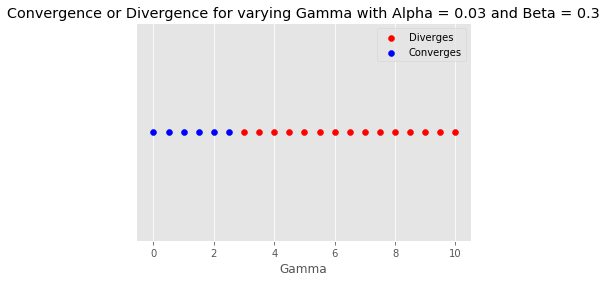

In [604]:
lis_conv = []
lis_div = []

for i in range(21):
    if results[i] == 0:
        lis_div.append(gamma_list[i])
    else:
        lis_conv.append(gamma_list[i])
      
    

#Show the plot   
plt.style.use('ggplot')
plt.title("Convergence or Divergence for varying Gamma with Alpha = 0.03 and Beta = 0.3")
plt.scatter(lis_div, [0 for i in lis_div], c = 'r', label = "Diverges")
plt.scatter(lis_conv, [0 for i in lis_conv], c = 'b', label = "Converges")
plt.xlabel("Gamma")
plt.yticks([])
plt.legend()
plt.show()

From this graph, we can see that decreasing gamma leads to convergance. Decreasing gamma means that the difference in nodes opinions must be larger in order for their edge weight to decrease, which suggests that a decreasing gamma should lead to convergance, which is confirmed by our test.

# Modified Model

We now look at the two modifications that I will be making to the model and analyzing. The first is changing the model so that people can have multiple opinions about different subjects. The second is that the alpha, beta, and gamma values can not be set for the entire simulation but instead sampled from a distribution for each node. 

## Multiple Opinions

The model introduces a new parameter, $k$, which is the number of opinions that each person has. Each person will have $k$ opinions, all between 0 and 1. There node color on the graph will be represented by the average of the $k$ opinions, but they will still have distinct values for each. There are a few things that must be decided in order to implement this model. The first is if people will have the same opinion for all $k$ of their opinions when they start out. This would be exploring a real life scenario where people's opinions about all topics are correlated. However, in this model, we will stick to examining what happens if people's opinions are not correlated with their other opinions.  This model is appropriate to answer the question of trying to see if having multiple opinions leads to people converging or diverging, and thus that will be the focus of our analysis. Another important aspect to be considered is if the time frame should be extended. With our base model, we let the simulation run 20,000 steps. We could potentially let the simulations run with $k$ * 20,000 steps, to account for the lowered amount of conversations each person will have about each opinion due to the larger number of opinions. However, this gives much more importance to the edge weights, as they will be changed $k$ times as many times. Thus, in this model we will keep the update steps to 20,000.

This is an improvment on the previous model because in the real world, people have opinions on multiple things. Some of these opinions will affect each other, while others may not, and friendships can be based on one strong shared opinion or by a combination of more, less related opinions. Thus, this model allows for understanding about the complexity that having multiple opinions on multiple topics can add to social dynamics.

## Personalized Parameters

The second aspect of the model we will change is having personalized parameters for each node. Instead of having a set alpha, beta and gamma for the simulation, each node will have their own alpha, beta, and gamma values. These will be chosen from a distribution. There are many distributions that could be used, but for this analysis, I will use a normal distribution. It is important to note that the parameters have specific ranges that they must fall in. Accordingly, we can make a modified normal distribution to do this. We can create a normal distribution sampler where if it sample a value outside of the range, it samples again untill it gets a value within the range. This can be thought of as the normal distribution but only over a specific range, with the rest of the distribution cut off. It is also worth noting that while the alpha parameter affects each individual node, the beta and gamma parameters are used on interactions between two nodes. Accordingly, the alpha used in the opinion update equation will be of the individual node, but the beta and gamma in the edge update equation will be the average of both nodes's paramters.

This is an improvement on the previous model because in the real world, people have different attributes, and change their opinions or relationships with different speeds. Some people are quick to make or lose friends, while others change much more slowly, and the same for opinions. Thus, including varying parameters more accurately accounts for the variance in real people.


## Multiple Opinions Analysis

In order to understand the change in dynamics with our new model that includes multiple opinions, we will examine two nodes with two opinions each. The simplest computational analysis of this scenario would be to run our simulation on only two nodes, so instead we will analyze generally what would happen. The different opinion values will not directly affect each other, but rather will both be influenced by the change in edge weights. The model randomally selects between the two opinions, so this can be simplified by assuming that it alternates between the two opinions each update. We can then envision two scenarios, the first being where both opinions lead to decreasing (or increasing) edge weights, and the other where one leads to decreasing edge weights and the other leads to increasing edge weights.

In the first scenario, it is clear that if the edge was going to decrease with only the first opinion, adding the second opinion (where the edge would also decrease) would not change this behaviour, but instead only speed up or slow down the rate of decrease. The second scenario is more interesting. On alternating updates, the edge will increase and decrease its weight. Thus, it seems that if either of the two opinions (large difference or small difference) was big enough, it would overpower the other opinion and lead to the edge following the progression of the dominant opinion.

With both scenarios, an important point to note is that the edge weight will change twice as often as the opinions change. If the opinions are leading the edge in the same direction, it seems that the edge weight will change faster than the opinions will change. This will lead to the eventual outcome (either strong edge or no edge) occuring more quickly. Thus, if we model this with all opinions of a node taking the same initial value, it seems that this change would cause the same eventual outcome to occur, and possibly more quickly. However, if the opinions are making the edge weight increase and then decrease, another effect would happen. The edge weight would thus be changing more slowly than the opinions are changing. This is important, because the change of opinions is always towards each other. As such, the difference between the nodes for both of the opinions would be able to decrease for longer (as the edge weight would not be able to reach an extreme as quickly). This indicates that if an individual nodes opinions are different, that increasing the number of opinions would lead to more convergance, as the opinions would converge faster in comparison to the edge weight change, giving the nodes more time to reach a moderate position on their opinions. These hypothesis will be tested by running analytics on the model.

## Personalized Parameters Local Analysis

In order to understand how our new simulation works on the local level, we can imagine running the simulation on just two nodes. The major difference is that we now have different values of alpha, beta, and gamma for all nodes. In order to analyze this, we will first analyze the equation, and then create vector plots of which opinion differences and edge weights will lead to convergance and divergence, for varying differing values of parameters (alpha, beta, gamma).

Each vector plot wil show in which direction and by how much the weight of an edge and the difference in opinions will change. The lines race out the evolution of weight and opinoins over time. Purple lines result in the edge dissapearing while green lines result in an edge with a weight of 1.
 
 

### Alpha 
The first analysis is changing alpha. From the equation, we know that alpha represents how quickly a node will change its opinion. The most important difference is that nodes can now change their opinions by different amounts. Thus, one node might change by a lot, while the other doesn't change much. We want to know what happens when two nodes have different alpha values and continusly have conversations with each other. In the below cells we will see a vector plot with two alphas, a beta and a gamma. The first alpha is set to 0.03, the beta is set to 0.4 and the gamma is set to 4. The second alpha ranges from 0.0001 to 0.5. We will analyze the change of the vector field as the second alpha changes.


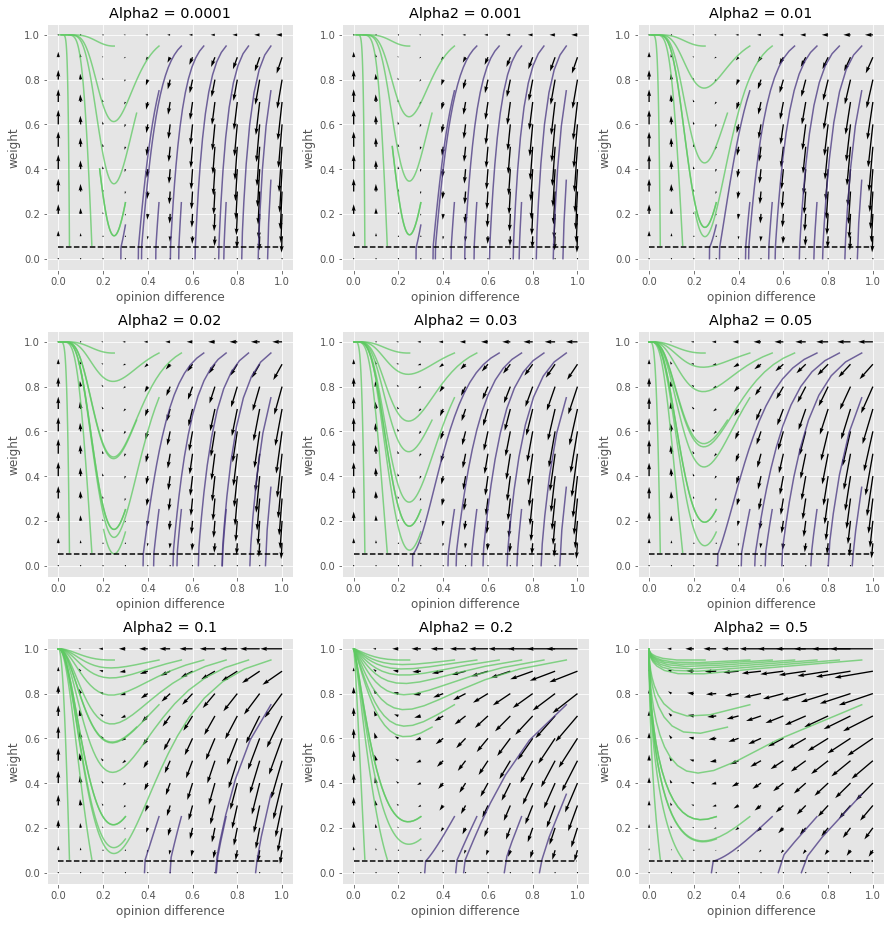

In [646]:
from matplotlib import pyplot
import itertools
import scipy

alpha1 = 0.03
alpha2 = 0.03
beta = 0.3
gamma = 4

def vector_field(alpha1, alpha2, beta, gamma, title):
    cmap = pyplot.cm.viridis  # color map to use

    # Plot traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.25],[0.45, 0.25],[0.55, 0.25],[0.75, 0.25],
        [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o_1 = alpha1 * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            #added delta_0_2 to be the change in the second nodes opinion
            delta_o_2 = alpha2 * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o_1, ow[-1][1] - delta_o_2, new_weight])
        pyplot.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -(alpha1 + alpha2) * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    pyplot.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    pyplot.xlabel('opinion difference')
    pyplot.ylabel('weight')
    pyplot.plot([0, 1], [0.05, 0.05], 'k--')
    pyplot.axis('square')
    pyplot.title(title)

plt.figure(figsize=(15,16))
alpha_list = [0.0001,0.001,0.01,0.02,0.03,0.05,0.1, 0.2, 0.5]
for i in range(len(alpha_list)):
    plt.subplot(3,3,i+1)
    vector_field(alpha1, alpha_list[i], beta, gamma,"Alpha2 = "+str(alpha_list[i]))
pyplot.show()



The above plots show some important information about the behaviour of alpha. The center plot, with alpha2 = 0.03, is the plot for what our normal model would do (both alpha values the same). If we look at the 1st plot, we see that the area which leads to the edge disapearing has gotten slightly bigger, but not by much. However, as alpha2 increases, much more of the vector field leads to a strong connection. This indicates that the addition of a high alpha dramatically increase the liklihood of an edge going to weight 1, while the addition of a very low alpha has a small increase on the liklihood of an edge going to weight 0. It is important to note that this is partly due to much larger ability for alpha to increase. A moderately large alpha (0.03) is what generally makes the model work, and it can only decrease so much but can increase a lot. Looking at the plot with alpha2 = 0.5 is the closest to the amount of change we see between 0.0001 and 0.03 (0.05 and 0.03) in the opposite direction. This again shows a small change, with convergance being slightly more likely. Thus, from this we conclude that small changes in alpha have small affects in the expected direction, and that big changes can show big affects. It is ipmortant to note that the 0.0001 and 0.5 alpha values are realistic, being a person who barely changes her mind and a person who changes their mind very easily. However, the small changes (to something like 0.05) are more likely to occur when sampling from a distribution.

### Beta and Gamma
We can now look at how having different beta and gamma values impacts two nodes. 

Note that with the beta values and the gamma values, the edge weight equation just takes the average of the two values. Thus, having different beta and gamma values is just like having one beta and one gamma value that is the appropriate average. We already know what increases and decreases in beta and gamma have on the convergance of the network as a whole. In order to see their impact on individual nodes, we can create vector plots with varying beta values and gamma values. There will be three beta plots and 3 gamma plots. While holding the other factors constant, I will plot a low medium and high value of the specific parameter. The change between the medium to high indicates the second node having a much larger value, while the change between medium to low indicates the second node having a much smaller value.


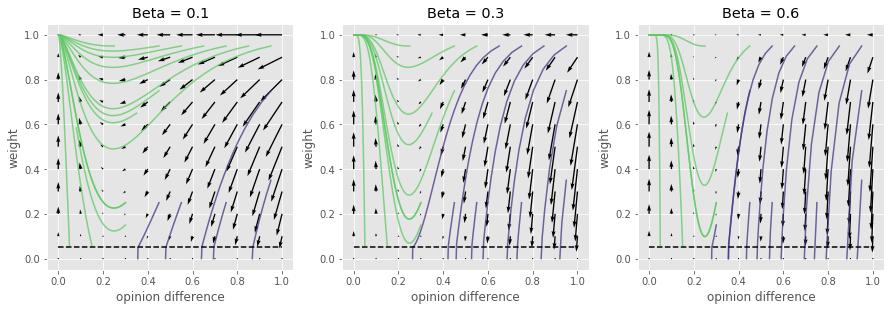

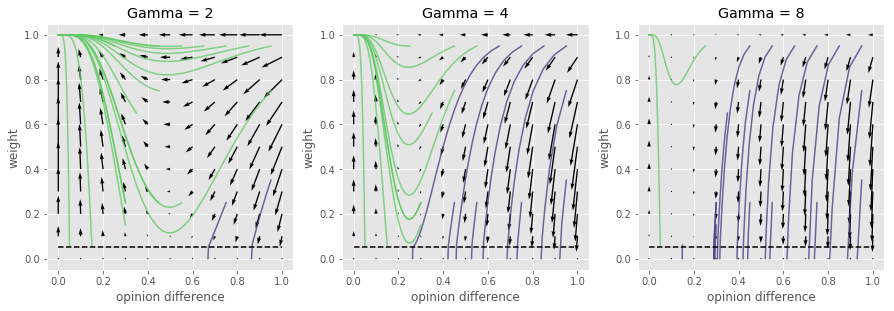

In [647]:
plt.figure(figsize=(15,6))
beta_list = [0.1,0.3,0.6]
for i in range(len(beta_list)):
    plt.subplot(1,3,i+1)
    vector_field(alpha1, alpha1, beta_list[i], gamma,"Beta = "+str(beta_list[i]))
pyplot.show()

plt.figure(figsize=(15,6))
gamma_list = [2,4 , 8]
for i in range(len(gamma_list)):
    plt.subplot(1,3,i+1)
    vector_field(alpha1, alpha1, beta, gamma_list[i],"Gamma = "+str(gamma_list[i]))
pyplot.show()

We can see similar changes occuring for changing both beta and gamma. Low values of beta and gamma lead to the two nodes being much more likely to converge, while high values lead to the two nodes being more likely to diverge. This is again in accordance with the impacts we see from changing beta and gamma for the whole simulation. From the above graphs, it is also important to notice that changes in gamma have a larger impact than changes in beta, leading to larger vector lines.

# Random Graph

I chose the Wattz Strograph random graph as it is one of the simplest random graphs. I wanted to have my model be as basic as possible and understand what the changes that the changing paramters create from my model do on a random graph. For further research, it would be interesting if the conclusions that I make hold for other random graphs, or small-world or other more realistic connection graphs.



# Implementation

Below is the implementation in python of the previuosly discussed, updated model. It now has a 

In [791]:
class SDS_mod:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, alpha_std = None, beta=0.3, beta_std = None,
                 gamma=4, gamma_std = None, k = 1 ,same_opinion = False):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
                small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
                match neighboring nodes' opinions during interactions.
                Default: 0.03.
            
            alpha_std(float) If this is left as None, the alpha values will all be the same
                (the alpha attribute), but if this is set to a value, the alpha values will
                be sampled from a normal distribution with mean = alpha and std = alpha_std.
                Note that the normal distribution is cutoff so that the values will be 
                within (0,.5].

            beta (float) The rate at which edge weights are changed in
                response to differing opinions. Default: 0.3.

            beta_std(float) If this is left as None, the beta values will all be the same
                (the beta attribute), but if this is set to a value, the beta values will
                be sampled from a normal distribution with mean = beta and std = beta_std.
                Note that the normal distribution is cutoff so that the values will be 
                within (0,1).

            gamma (float) The pickiness of nodes. Nodes with opinions differing
                by more than 1/gamma will result in an edge weight decreasing.
                Default: 4.
                
            gamma_std(float) If this is left as None, the gamma values will all be the same
                (the gamma attribute), but if this is set to a value, the gamma values will
                be sampled from a normal distribution with mean = gamma and std = gamma_std.
                Note that the normal distribution is cutoff so that the values will be greater 
                than 0.
                
            k (int) The number of opinions each node has. Default = 1
            
            same_opinions (Bool) If True, each node has the same value for each of their opinions
            If False, a random value is chosen for each of the k opinions
            
        '''
        self.network_size = network_size
        
        self.alpha = alpha
        self.alpha_std = alpha_std
        self.beta = beta
        self.beta_std = beta_std
        self.gamma = gamma
        self.gamma_std = gamma_std
        
        self.opinions = []
        for i in range (k):
            self.opinions.append("opinion" + str(i))
        self.same_opinion = same_opinion
    
    def norm_sampler(self,mean,std, low, high):
        done = False
        while not done:
            samp = np.random.normal(mean, std)
            if samp > low and samp < high:
                done = True
        return samp
               

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        # EXPLAIN WHY CHOSE THIS
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            ## add attributes to node
            # either all the same or all different
            if self.same_opinion == True:
                val = random.randint(0, 1)
                for opinion in self.opinions:
                    self.graph.nodes[node][opinion] = val
            else:
                for opinion in self.opinions:
                    self.graph.nodes[node][opinion] = random.randint(0, 1)
            # set the values for all nodes
            if self.alpha_std == None:
                self.graph.nodes[node]['alpha'] = self.alpha
            else:
                self.graph.nodes[node]['alpha'] = self.norm_sampler(self.alpha, self.alpha_std, 0, 0.5)
            if self.beta_std == None:
                self.graph.nodes[node]['beta'] = self.beta
            else:
                self.graph.nodes[node]['beta'] = self.norm_sampler(self.beta, self.beta_std, 0, 1)
            if self.gamma_std == None:
                self.graph.nodes[node]['gamma'] = self.gamma
            else:
                self.graph.nodes[node]['gamma'] = self.norm_sampler(self.gamma, self.gamma_std, 0, np.inf)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0


    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()

        node_color = [np.mean([self.graph.nodes[i][opinion] for opinion in self.opinions])
                        for i in self.graph.nodes]
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color= node_color,
            vmin=0, vmax=1,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            #choose an opinion from the opinions list (if only 1, it is always chosen)
            opinion = random.choice(self.opinions)
            opinions = [self.graph.nodes[n][opinion] for n in edge]
            #find the alphas of the two nodes
            alphas = [self.graph.nodes[n]['alpha'] for n in edge]
            #find the beta and gamma to be used (average the two)
            beta = np.mean([self.graph.nodes[n]['beta'] for n in edge])
            gamma = np.mean([self.graph.nodes[n]['gamma'] for n in edge])
            for i in [0, 1]:
                self.graph.nodes[edge[i]][opinion] = (
                    opinions[i] + alphas[i] * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                beta * weight * (1-weight) *
                (1 - gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

## Multiple Opinion Analysis

The first thing we will analyze is the number of opinions. In the below code, we create a function that displays scatter plots of the data at k = 1 to k =5, with network diagrams shown at k=2 and k =4. We will run this code on varying alpha levels to understand the change that a change in k makes at varying levels.

In [751]:
def k_scat(sim, title):
    lis = []
    for j in range(len(sim.opinions)):
        lis.append([])
        for i in list(sim.graph.nodes()):
            lis[j].append(sim.graph.nodes[i][sim.opinions[j]])
    plt.title(title)
    for j in range(len(lis)):
        plt.scatter([x for x in range(1,51)],lis[j])
    plt.xlabel("Node")
    plt.ylabel("Opinion")


    
def k_plot(alpha, beta, gamma):
    plt.figure(figsize=(20,5))
    for k in range (1,6):
        sim_1 = SDS_mod(alpha = alpha, beta = beta, gamma = gamma, k = k)
        sim_1.initialize()
        for i in range(20000):
            sim_1.update()
        plt.subplot(1,5,k)
        k_scat(sim_1, "K = "+ str(k))
    plt.show()
    
def full_analysis(alpha):
    print ("alpha = ", alpha,)
    k_plot(alpha,.3,4)

    print ("Alpha =",alpha, "k =", 2)
    sim_1 = SDS_mod(alpha = alpha, beta = 0.3, gamma = 4, k = 2)
    sim_1.initialize()
    for i in range(20000):
        sim_1.update()
    sim_1.observe()
    plt.show()

    print ("Alpha =",alpha, "k =", 4)
    sim_1 = SDS_mod(alpha = alpha, beta = 0.3, gamma = 4, k = 4)
    sim_1.initialize()
    for i in range(20000):
        sim_1.update()
    sim_1.observe()
    plt.show()

alpha =  0.01


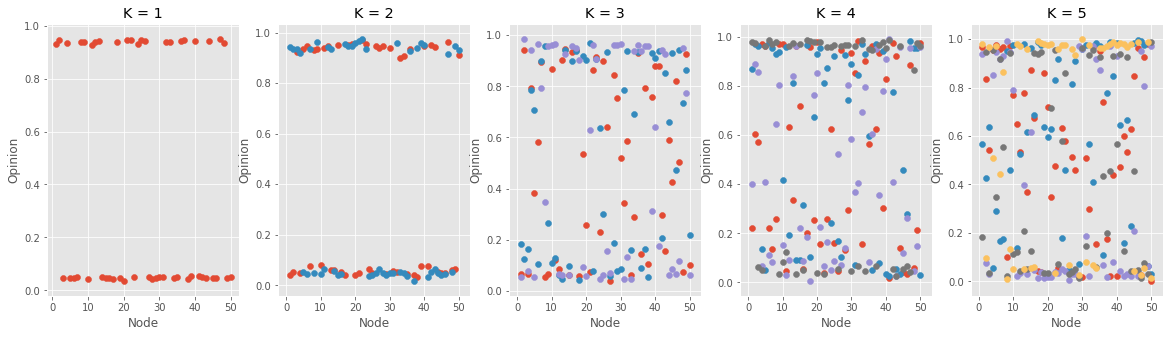

Alpha = 0.01 k = 2


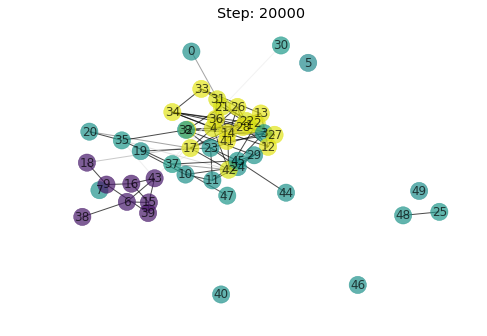

Alpha = 0.01 k = 4


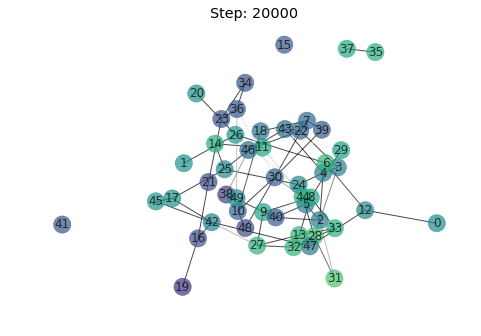

In [745]:
full_analysis(0.01)

The first case we analyzed was increasing k on a clearly divergent graph. This was done by setting alpha to 0.01. From the scatterplot with k = 1, we can clearly see that the graph is divergent. From the scatter plot with k = 2, we see that both opinions have diverged. However, when looking at the network diagram, we can see that 3 distinct groups have formed, that have both opinions at 1, both opinions at 0, and the other with one oninion extreme one way and the other the other way. When we increase k to 4, we see many opinions still extreme, with a scattering of middling opinions. The network visualization for k = 4 shows that this graph is between convergent and divergent. There is no clear divergent groups, and one connected group, but many nodes are not connected at all, and the connectedness in this group is not strong. We can also see that the nodes still have differing opinion values. We can call this type of group a "semi - converged " group.

alpha =  0.05


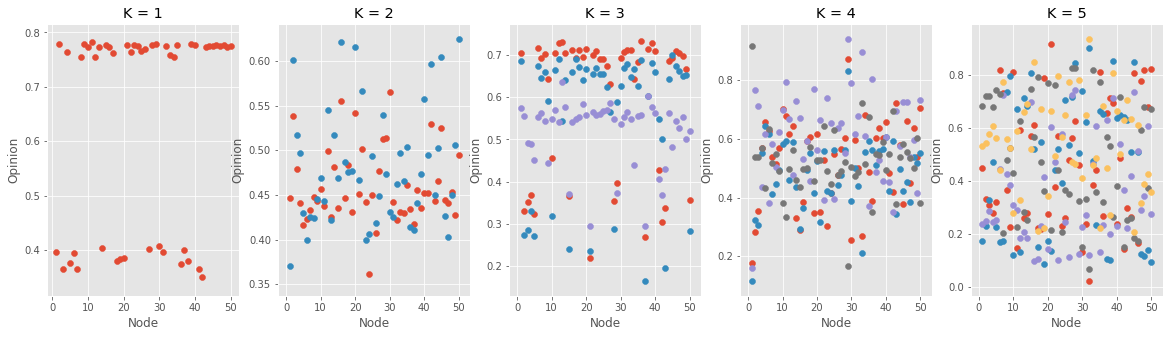

Alpha = 0.05 k = 2


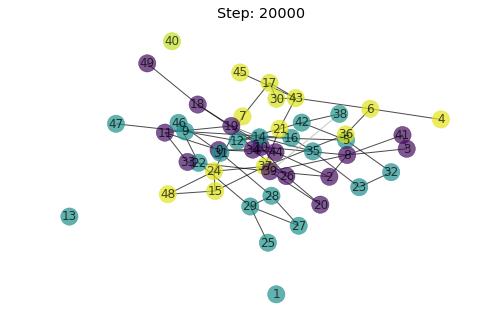

Alpha = 0.05 k = 4


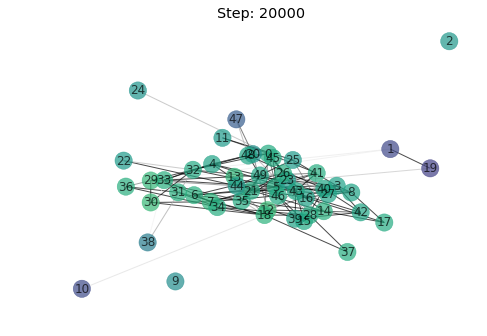

In [741]:
full_analysis(0.05)

With a higher alpha value of 0.05, we still see the same behaviour for k = 1. At k = 2, we see a very different scatter plot, as the opinion values are scattered throughout a middling range. The network diagram still shows the pattern of having 3 distinct groups. However, when we increase k to 4, we see a convergent group, with most nodes being connected to each other in a well connected group (which can be seen from the network diagram). The scatter plot for k = 4 also shows this pattern, as it is much less divided than alpha = 0.01

alpha =  0.1


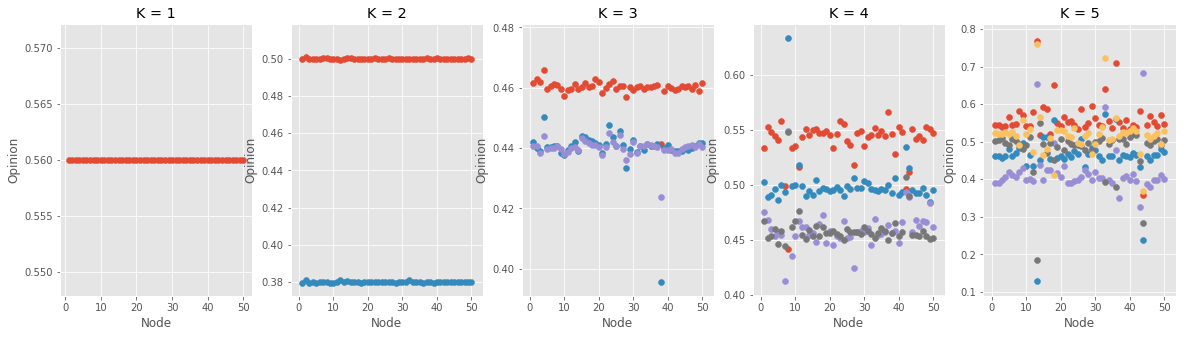

Alpha = 0.1 k = 2


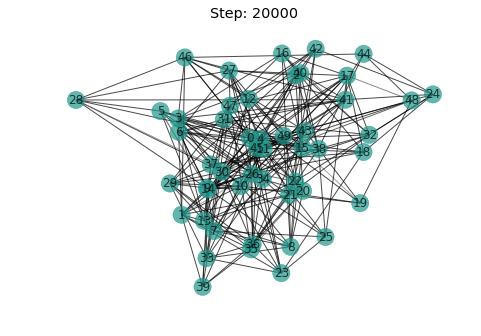

Alpha = 0.1 k = 4


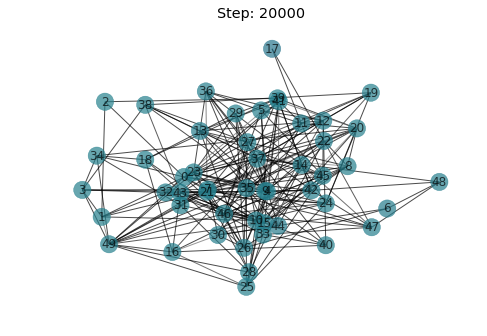

In [752]:
full_analysis(0.1)

Finally, we wee the effect of k on a graph with alpha = 0.1. The first thing to notice is that on the scatter plot, the behaviour is still incredibly convergent, even as k increases. Both scatter plots are also convergant, showing extreme amounts of connectivity and similarity. 

We will also do one final analysis, with a k value of 20.

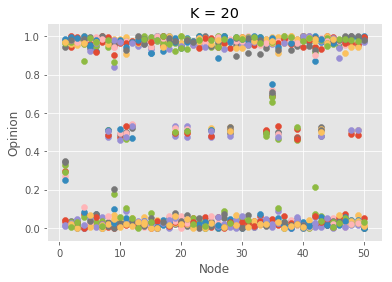

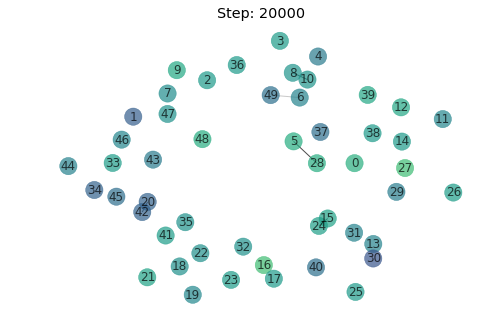

In [753]:
sim_1 = SDS_mod(alpha = 0.03, beta = 0.3, gamma = 4, k = 20)
sim_1.initialize()
for i in range(20000):
    sim_1.update()
plt.figure()
k_scat(sim_1, "K = "+ str(20))
plt.show()

sim_1 = SDS_mod(alpha = 0.03, beta = 0.3, gamma = 4, k = 20)
sim_1.initialize()
for i in range(20000):
    sim_1.update()
sim_1.observe()
plt.show()

From this extremely high k value, we can see that the network is not connected at all, and almost all the opinion values are still at either 0 or 1. This is resulting from the high k value meaning that no node can form real connections with other nodes, as one of their diverging opinions will quickly break the connection they have.

### Conclusions

From these tests, we can draw some general conclusions about how changing k will affect the behavior of our model. We can initally say that increasing k with paramaters that are already bound to convergance leads to even more strong convergance. 

The more interesting affect is that increasing k creates convergance on graphs with parameters that wouldn't normally converge. With graphs strongly situation in the divergent part of the parameter space, increasing k a small amount intially creates multuple (more than 2) divergent subgroups, but increasing it enough creates one loosely connected "semi-converging group". With more borderline parameter setting, increasing k can bring the full change from a divergent graph to a convergent graph.

This indicates that when there are more than a few differnt things that people have opinions about, people will generally converge into one group of friends. The opinions are not all exactly the same but there is general enough consensus among people to create one convergent group.

Finally, increasing k to values that are too high leads to complete disconnectivity in the network, with no edges at all. This would indicate a society with many controversial topics, where if you can't be friends with someone who disagrees with you on one of these controversial topics, you will have no friends at all, as there is no one who agrees with you compeltely

# Personalized Parameters Analysis

The next thing to do is to analyze the change from having standard parameters to having peoples' parameters sampled from a distribution.

The following lines of code increase the standard deviation of each parameter starting from 0 to large standard deviation. This is done for three graphs at various alpha levels


In [819]:
alpha = 0.03
beta = 0.3
gamma = 4
alpha_std = 0.05
beta_std = 0.5
gamma_std = 1

def comparison(alpha, alpha_std,  beta,beta_std, gamma, gamma_std):
    print (alpha, beta, gamma)
    print ("With std ", alpha_std,beta_std, gamma_std)
    sim_1 = SDS_mod(alpha = alpha, alpha_std = alpha_std, beta = beta,beta_std = beta_std, gamma = gamma, gamma_std = gamma_std)
    sim_1.initialize()
    for j in range (5):
        for i in range(4000):
            sim_1.update()
    sim_1.observe()
    plt.show()
    lis = []
    for i in range(len(sim.graph.nodes())):
        lis.append(sim_1.graph.nodes[i][sim_1.opinions[0]])
    std = (np.std(lis))
    print ("Standard Deviation is: ", std)
    print ("________________________ ")
    print ("")

    
std_list = [[None, None, None],[0.005,0.05,0.5],[0.01,0.1,1],[0.05,0.5,5]]
    

0.03 0.3 4
With std  None None None


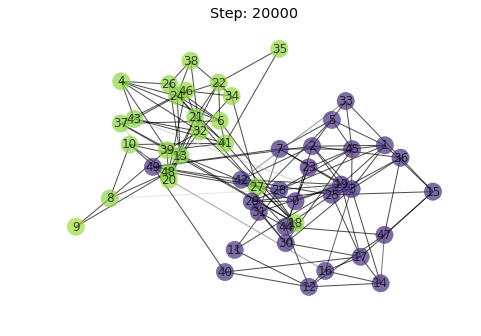

Standard Deviation is:  0.345771313232
________________________ 

0.03 0.3 4
With std  0.005 0.05 0.5


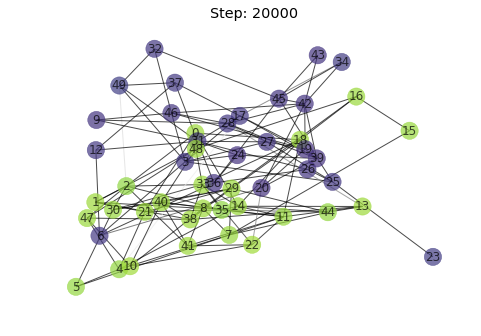

Standard Deviation is:  0.342784803919
________________________ 

0.03 0.3 4
With std  0.01 0.1 1


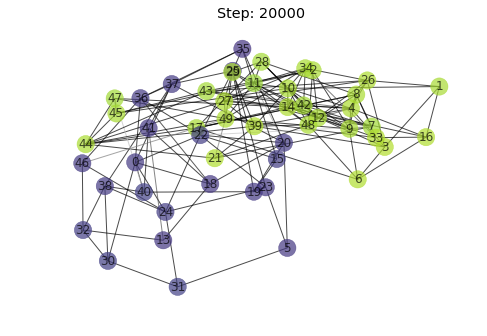

Standard Deviation is:  0.345981275046
________________________ 

0.03 0.3 4
With std  0.05 0.5 5


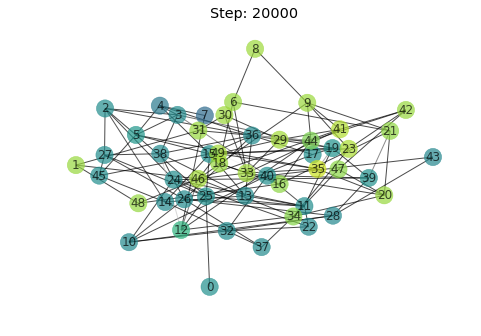

Standard Deviation is:  0.185842105239
________________________ 



In [825]:
alpha = 0.03 
for alpha_std, beta_std, gamma_std in std_list:
    comparison(alpha, alpha_std,  beta,beta_std, gamma, gamma_std)


When the graph is already diverging, increasing the standard deviation slightly increase convergance, but in general still leads to divergance.

0.05 0.3 4
With std  None None None


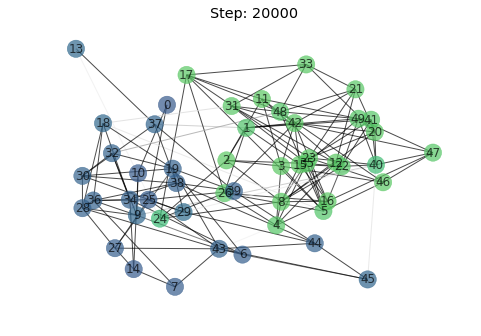

Standard Deviation is:  0.213943415682
________________________ 

0.05 0.3 4
With std  0.005 0.05 0.5


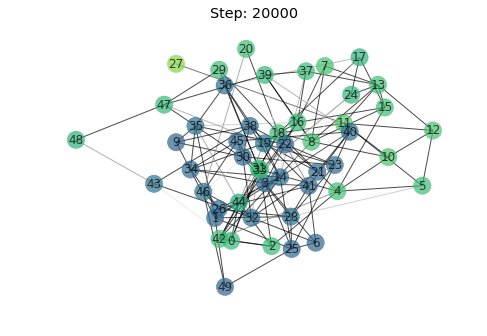

Standard Deviation is:  0.172029593902
________________________ 

0.05 0.3 4
With std  0.01 0.1 1


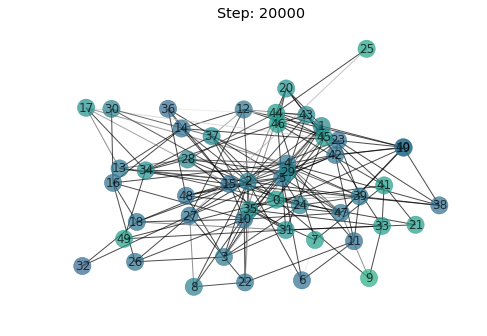

Standard Deviation is:  0.0788851842179
________________________ 

0.05 0.3 4
With std  0.05 0.5 5


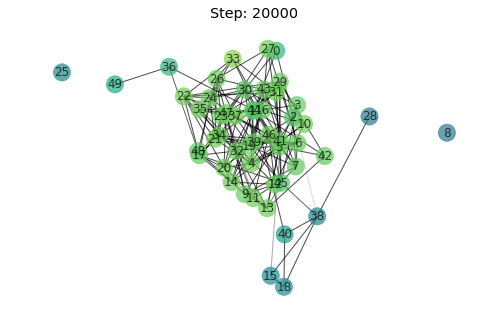

Standard Deviation is:  0.111250810468
________________________ 



In [826]:
alpha = 0.05
for alpha_std, beta_std, gamma_std in std_list:
    comparison(alpha, alpha_std,  beta,beta_std, gamma, gamma_std)


When the graph is on the borderline of convergance, the increase in the standard deviation at first makes the graph converge, but then leads to it diverging with too high of standard deviation.

0.1 0.3 4
With std  None None None


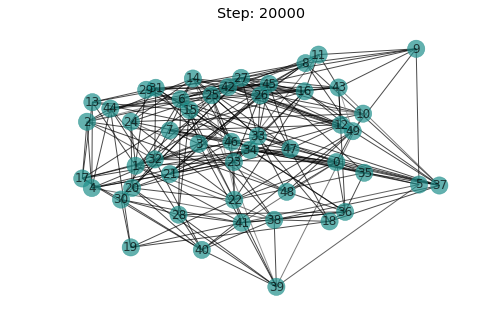

Standard Deviation is:  2.07046112942e-07
________________________ 

0.1 0.3 4
With std  0.005 0.05 0.5


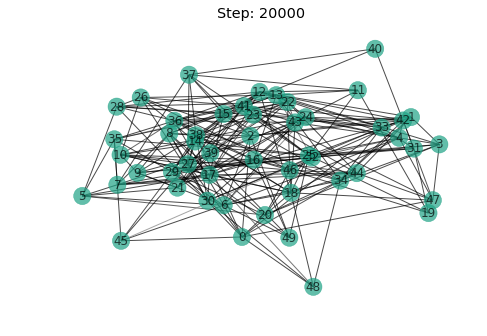

Standard Deviation is:  1.34219192262e-07
________________________ 

0.1 0.3 4
With std  0.01 0.1 1


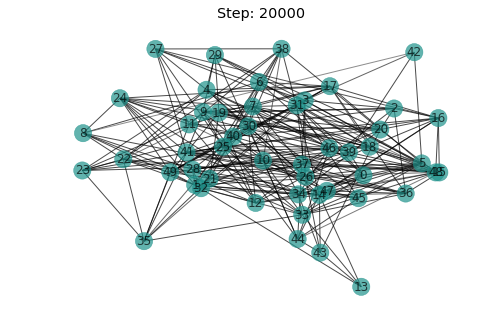

Standard Deviation is:  8.36615744451e-08
________________________ 

0.1 0.3 4
With std  0.05 0.5 5


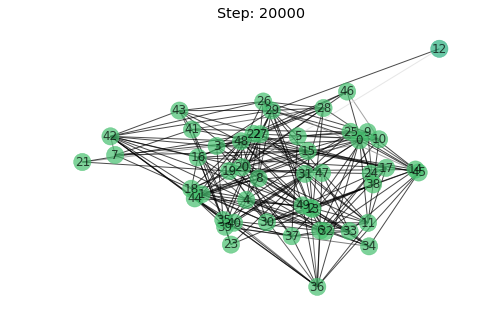

Standard Deviation is:  0.0100660717411
________________________ 



In [824]:
alpha = 0.1
for alpha_std, beta_std, gamma_std in std_list:
    comparison(alpha, alpha_std,  beta,beta_std, gamma, gamma_std)


The above figures show us that increasing the standard deviation when the graph is already very converging, can lead to an increase in the standard deviation but not enough to make it diverge.

Thus, as a whole, increasing the standard deviation of all parameters has mixed effects, possibly changing the graph from convergant to divergant, but also having the ability to change it back. In general however, the first graph of each figure, with a small standard deviation is the most important, as in real life people's parameters might be different but in general rather close together. Thus, the conclusion from this analysis is that while large standard deviations can have large and varying impacts on the graph, small standard deviations (that we might see in the real world) are generally not going to influence the behaviour of the model that much. 